In [1]:
import os
import umap
import torch
import itertools
from core import *
import numpy as np
import pandas as pd
import pickle as pkl
from torch import nn
import os.path as op
from tqdm import tqdm
from time import time
from Bio import SeqIO
from copy import deepcopy
from torch.optim import Adam
from tpot import TPOTRegressor
import torch.nn.functional as F
import matplotlib.pyplot as plt
from capsules.capsules import *
from IPython.display import Image
from qhoptim.pyt import QHM, QHAdam
from matplotlib.lines import Line2D
from torch.autograd import Variable
from matplotlib.patches import Patch
from scipy.stats import spearmanr, pearsonr
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, matthews_corrcoef, precision_score, recall_score

/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/bakirillov/anaconda3/envs/lapki/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: F

In [2]:
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset

In [3]:
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.models import ApproximateGP, ExactGP 
from sklearn.metrics import accuracy_score
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, GridInterpolationKernel
from gpytorch.mlls import VariationalELBO, VariationalELBOEmpirical, DeepApproximateMLL
from gpytorch.distributions import MultivariateNormal
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP

In [4]:
DATAPATH = "/home/bakirillov/HDD/data/genomes/all_guides_chr22.tsv"
ANNOTATION = "/home/bakirillov/HDD/data/genomes/annotation.csv"

In [5]:
annotation = pd.read_csv(ANNOTATION, header=1)[["Start", "Stop", "Gene symbol"]]
annotation = list(
    zip(
        annotation["Start"].values, annotation["Stop"].values, 
        annotation["Gene symbol"].values
    )
)
annotation = sorted(annotation, key=lambda x: x[0])

In [6]:
transformer = get_Cas9_transformer(True)

In [7]:
%%bash

ls /home/bakirillov/HDD/data/CRISPR-CAD/Weissman/

41587_2019_387_MOESM3_ESM.zip
Table_S10_compact_library_sequences_revised.txt
Table_S11_compact_screen_phenotypes_revised.txt
Table_S12_compact_screen_sgRNA_counts_revised.txt
Table_S13_PS_gene_descriptions.xlsx
Table_S14_perturb_seq_cell_counts.txt
Table_S15_perturb-seq_screen_sgRNA_counts.txt
Table_S16_perturb-seq_screen_phenotypes.txt
Table_S17_oligonucleotide_sequences.xlsx
Table_S1_sgRNA_sequences.xlsx
Table_S2_large-scale_library_sequences_revised.txt
Table_S3_large-scale_screen_sgRNA_counts.txt
Table_S4_large-scale_screen_phenotypes.txt
Table_S5_constant_region_sequences.txt
Table_S6_constant_region_screen_sgRNA_counts.txt
Table_S7_constant_region_screen_phenotypes.txt
Table_S8_machine_learning_input.txt
Table_S9_genome-wide_predicted_activities_revised.txt.gz


In [8]:
s13seqs = pd.read_excel(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S13_PS_gene_descriptions.xlsx"
)

In [9]:
s13seqs

,ALDOA,Aldolase A; glycolytic enzyme
0,ATP5E,ATP synthase subunit
1,BCR-ABL,Fusion gene; drives CML-derived K562 cells
2,CAD,Pyrimidine nucleotide biosynthesis enzyme; cat...
3,CDC23,Anaphase promoting complex/cyclosome component
4,COX11,Mitochondrial respiratory chain; cytochrome c ...
5,DBR1,Lariat debranching enzyme; required for lariat...
6,DUT,dUTP pyrophosphatase; involved in thymidine bi...
7,EIF2S1,eIF2α; Translation initiation factor; translat...
8,GATA1,Erythroid-lineage transcription factor
9,GINS1,DNA replication initiation factor


In [10]:
s14 = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S14_perturb_seq_cell_counts.txt",
    sep="\t"
)
s15 = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S15_perturb-seq_screen_sgRNA_counts.txt",
    sep="\t"
)
s16 = pd.read_csv(
    "/home/bakirillov/HDD/data/CRISPR-CAD/Weissman/Table_S16_perturb-seq_screen_phenotypes.txt",
    sep="\t"
)

In [11]:
s16

,Unnamed: 0,sequence,gene,gamma_day5,gamma_day10,relative_activity_day5,relative_activity_day10
0,ALDOA_+_30077139.23-P1P2_00,GGTCACCAGGACCCCTTCTG,ALDOA,-0.412746,-0.366469,1.000000,1.000000
1,ALDOA_+_30077139.23-P1P2_06,GGTCACCAGGATCCCTTCTG,ALDOA,-0.396687,-0.348503,0.961091,0.950977
2,ALDOA_+_30077139.23-P1P2_07,GGTCACCAGGCCCCCTTCTG,ALDOA,-0.360892,-0.335059,0.874369,0.914291
3,ALDOA_+_30077139.23-P1P2_13,GGTCACCAGGACCCCTTTTG,ALDOA,0.017063,-0.000220,-0.041340,0.000601
4,ALDOA_+_30077139.23-P1P2_14,GGTCACCAGGACCGCTTCTG,ALDOA,-0.175243,-0.156611,0.424579,0.427353
5,ATP5E_-_57607036.23-P1P2_00,GGTGTCCAGGGGCACTCTGT,ATP5E,-0.176898,-0.224723,1.000000,1.000000
6,ATP5E_-_57607036.23-P1P2_01,GGTGTCCTGGGGCACTCTGT,ATP5E,-0.209658,-0.228373,1.185190,1.016242
7,ATP5E_-_57607036.23-P1P2_04,GGTGTCCAGGAGCACTCTGT,ATP5E,-0.097933,-0.120406,0.553610,0.535799
8,ATP5E_-_57607036.23-P1P2_14,GGTGTCCAGGGGCACTGTGT,ATP5E,-0.012330,-0.035062,0.069701,0.156022
9,ATP5E_-_57607036.23-P1P2_16,GGTGTCCAGGGGCGCTCTGT,ATP5E,-0.161607,-0.165585,0.913560,0.736842


In [12]:
from weblogolib import *

In [13]:
with open("test.fa", "w") as oh:
    for a in s16["sequence"].values:
        oh.write(">\n"+a+"\n")

In [14]:
fin = open("test.fa")
seqs = read_seq_data(fin)

In [15]:
logodata = LogoData.from_seqs(seqs)

In [16]:
logooptions = LogoOptions()
logooptions.title = "Most Active Cluster Logo"
logoformat = LogoFormat(logodata, logooptions)

In [17]:
png = png_formatter(logodata, logoformat)

In [18]:
with open("logo.png", "wb") as oh:
    oh.write(png)

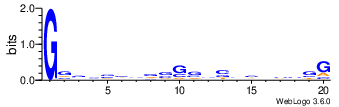

In [19]:
Image("logo.png")

In [20]:
cnn_mse_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_mse = DKL(cnn_mse_encoder, [1,5*32]).cuda()
cnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_mse59.ptch"))
cnn_mse = cnn_mse.eval()

In [21]:
rnn_mse_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_mse = DKL(rnn_mse_encoder, [1,5*32]).cuda()
rnn_mse.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_mse59.ptch"))
rnn_mse = rnn_mse.eval()

In [22]:
cnn_elbo_encoder = GuideHN(21, 32, 1360, n_classes=5).cuda()
cnn_elbo = DKL(cnn_elbo_encoder, [1,5*32]).cuda()
cnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/cnn_elbo59.ptch"))
cnn_elbo = cnn_elbo.eval()

In [23]:
rnn_elbo_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_elbo = DKL(rnn_elbo_encoder, [1,5*32]).cuda()
rnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_elbo59.ptch"))
rnn_elbo = rnn_elbo.eval()

In [24]:
wl_encoder = GuideHRNN(21, 32, 3360, n_classes=5).cuda()
rnn_elbo = DKL(rnn_elbo_encoder, [1,5*32]).cuda()
rnn_elbo.load_state_dict(torch.load("../models/DeepHF/Wt/rnn_elbo59.ptch"))
rnn_elbo = rnn_elbo.eval()

In [25]:
w_encoder = GuideHN2d(
    23, capsule_dimension=32, n_routes=1600, n_classes=5, n_channels=2,
).cuda()
w_model = DKL(w_encoder, [1,5*32]).cuda().eval()
w_model.load_state_dict(torch.load("../models/Weissman/cnn59.ptch"))
w_model = w_model.eval()

In [26]:
%%bash

ls ../models/Weissman/

cnn59.ptch
cnn_mse59.ptch


In [27]:
n20 = s16["sequence"].values
l20 = s16["relative_activity_day5"].values

In [28]:
s16.columns

Index(['Unnamed: 0', 'sequence', 'gene', 'gamma_day5', 'gamma_day10',
       'relative_activity_day5', 'relative_activity_day10'],
      dtype='object')

In [29]:
n23 = sum([[a+"AGG", a+"TGG", a+"CGG", a+"GGG"] for a in n20], [])
l23 = sum([[a, a, a, a] for a in l20], [])

In [30]:
df = pd.DataFrame(
    {
        "sgRNA": n23, "Normalized efficacy": l23,
        "relative_activity_day5": l23, 
        "relative_activity_day10": sum([[a, a, a, a] for a in s16["relative_activity_day10"]], []),
        "gamma_day10": sum([[a, a, a, a] for a in s16["gamma_day10"]], []),
        "gamma_day5": sum([[a, a, a, a] for a in s16["gamma_day5"]], []),
        
    }
)

In [32]:
tds = DeepHFDataset(
    df, np.arange(df.shape[0]), transformer
)
tld = DataLoader(tds, shuffle=False, batch_size=256)
tb_cnn_mse_oa = []
tb_cnn_mse_va = []
tb_cnn_mse_ra = []
tb_rnn_mse_oa = []
tb_rnn_mse_va = []
tb_rnn_mse_ra = []
tb_cnn_elbo_oa = []
tb_cnn_elbo_va = []
tb_cnn_elbo_ra = []
tb_rnn_elbo_oa = []
tb_rnn_elbo_va = []
tb_rnn_elbo_ra = []
for transformed_batch, _ in tqdm(tld):
    tb_cnn_mse_o = cnn_mse_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_cnn_mse_ra.extend(tb_cnn_mse_o)
    tb_rnn_mse_o = rnn_mse_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_rnn_mse_ra.extend(tb_rnn_mse_o)
    tb_cnn_elbo_o = cnn_elbo_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_cnn_elbo_ra.extend(tb_cnn_elbo_o)
    tb_rnn_elbo_o = rnn_elbo_encoder(transformed_batch)[0].cpu().data.numpy()
    tb_rnn_elbo_ra.extend(tb_rnn_elbo_o)
    tb_cnn_mse = cnn_mse(transformed_batch)
    tb_cnn_mse_o = cnn_mse.likelihood(
        tb_cnn_mse[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_cnn_mse_v = cnn_mse.likelihood(
        tb_cnn_mse[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_cnn_mse_oa.extend(tb_cnn_mse_o)
    tb_cnn_mse_va.extend(tb_cnn_mse_v)
    tb_rnn_mse = rnn_mse(transformed_batch)
    tb_rnn_mse_o = rnn_mse.likelihood(
        tb_rnn_mse[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_rnn_mse_v = rnn_mse.likelihood(
        tb_rnn_mse[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_rnn_mse_oa.extend(tb_rnn_mse_o)
    tb_rnn_mse_va.extend(tb_rnn_mse_v)
    tb_cnn_elbo = cnn_elbo(transformed_batch)
    tb_cnn_elbo_o = cnn_elbo.likelihood(
        tb_cnn_elbo[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_cnn_elbo_v = cnn_elbo.likelihood(
        tb_cnn_elbo[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_cnn_elbo_oa.extend(tb_cnn_elbo_o)
    tb_cnn_elbo_va.extend(tb_cnn_elbo_v)
    tb_rnn_elbo = rnn_elbo(transformed_batch)
    tb_rnn_elbo_o = rnn_elbo.likelihood(
        tb_rnn_elbo[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_rnn_elbo_v = rnn_elbo.likelihood(
        tb_rnn_elbo[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_rnn_elbo_oa.extend(tb_rnn_elbo_o)
    tb_rnn_elbo_va.extend(tb_rnn_elbo_v)

100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


In [33]:
transformer2 = get_Cas9_transformer(False)

In [35]:
tb_w_oa = []
tb_w_va = []
tb_w_ra = []
tds2 = DeepHFDataset(
    df, np.arange(df.shape[0]), transformer2
)
tld2 = DataLoader(tds2, shuffle=False, batch_size=256)
for transformed_batch, _ in tqdm(tld2):
    batch_2d = torch.stack(
        [transformed_batch, transformed_batch]
    )
    batch_2d = batch_2d.permute(1, 0, 2, 3)
    tb_w_o = w_encoder(batch_2d)[0].cpu().data.numpy()
    tb_w_ra.extend(tb_w_o)
    tb_w = w_model(batch_2d)
    tb_w_o = w_model.likelihood(
        tb_w[0]
    ).mean.mean(0).cpu().data.numpy()
    tb_w_v = w_model.likelihood(
        tb_w[0]
    ).variance.mean(0).cpu().data.numpy()
    tb_w_oa.extend(tb_w_o)
    tb_w_va.extend(tb_w_v)

100%|██████████| 2/2 [00:00<00:00,  8.93it/s]


In [36]:
tb_cnn_mse_ra = np.stack(tb_cnn_mse_ra).reshape(-1, 5*32)
tb_rnn_mse_ra = np.stack(tb_rnn_mse_ra).reshape(-1, 5*32)
tb_cnn_elbo_ra = np.stack(tb_cnn_elbo_ra).reshape(-1, 5*32)
tb_rnn_elbo_ra = np.stack(tb_rnn_elbo_ra).reshape(-1, 5*32)
tb_w_ra = np.stack(tb_w_ra).reshape(-1, 5*32)
tb_w_ra = np.stack(tb_w_ra).reshape(-1, 5*32)

In [37]:
tb_cnn_mse_ra.shape

(512, 160)

In [38]:
for a in df.columns[2:]:
    print(a, spearmanr(df[a], tb_cnn_elbo_oa))

relative_activity_day5 SpearmanrResult(correlation=0.0985591651458464, pvalue=0.025739435231976075)
relative_activity_day10 SpearmanrResult(correlation=0.11282456017064389, pvalue=0.010623333304797701)
gamma_day10 SpearmanrResult(correlation=-0.34567875750324567, pvalue=8.12820854600865e-16)
gamma_day5 SpearmanrResult(correlation=-0.3084323945641153, pvalue=9.560240639912674e-13)


In [39]:
for a in df.columns[2:]:
    print(a, spearmanr(df[a], tb_cnn_elbo_va))

relative_activity_day5 SpearmanrResult(correlation=0.00033420779734407005, pvalue=0.9939809946228229)
relative_activity_day10 SpearmanrResult(correlation=0.006813567236830419, pvalue=0.8777687041940507)
gamma_day10 SpearmanrResult(correlation=-0.13565069427367352, pvalue=0.002096903076055503)
gamma_day5 SpearmanrResult(correlation=-0.14216295187832986, pvalue=0.0012583456047037928)


In [40]:
for a in df.columns[2:]:
    print(a, spearmanr(df[a], tb_w_oa))

relative_activity_day5 SpearmanrResult(correlation=0.2598955395897906, pvalue=2.38319396015891e-09)
relative_activity_day10 SpearmanrResult(correlation=0.22088800077574042, pvalue=4.455286919563462e-07)
gamma_day10 SpearmanrResult(correlation=-0.17419581197010628, pvalue=7.423087698668279e-05)
gamma_day5 SpearmanrResult(correlation=-0.09471044082225284, pvalue=0.03214257927247207)


In [41]:
for a in df.columns[2:]:
    print(a, spearmanr(df[a], tb_w_va))

relative_activity_day5 SpearmanrResult(correlation=0.2490316444166903, pvalue=1.1205538401818503e-08)
relative_activity_day10 SpearmanrResult(correlation=0.21059380069094927, pvalue=1.5277925286909894e-06)
gamma_day10 SpearmanrResult(correlation=-0.16422214872477398, pvalue=0.000189807799719317)
gamma_day5 SpearmanrResult(correlation=-0.0869569999230474, pvalue=0.04923748036479615)


In [42]:
import ncvis

In [43]:
nvis_cm = ncvis.NCVis()
nv_cm = nvis_cm.fit_transform(tb_cnn_mse_ra)

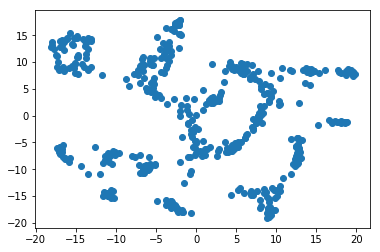

In [44]:
plt.scatter(nv_cm.T[0],nv_cm.T[1])

In [45]:
nvis_cm = ncvis.NCVis()
nv_cm = nvis_cm.fit_transform(tb_w_ra)

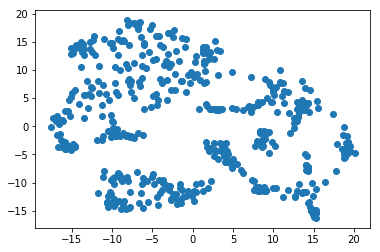

In [46]:
plt.scatter(nv_cm.T[0],nv_cm.T[1])